In [1]:
import sys
sys.path.append("..")
import Data as dt
import Temp_lib as lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
wdo = dt.load_data(ticker="WDO")
wdo.drop(columns=["Unnamed: 0"], inplace=True)

# data = dt.load_dataList(ticker_list=['A'])
# data = data['A'].loc['2012-01-01':'2015-01-01']
# plt.figure(figsize=(17, 4))
# plt.plot(data['close'])
# plt.show()

# **I. Data Processing**

In [3]:
# ==== I. Resample data ====
resampled_dfs =lib.extract_targetBars(
    data=wdo, 
    target_bars=100, 
    column_name="volume", 
    window_bars_estimation=10, 
    new_cols_methods="mean", 
    grouping_column="date", 
    n_jobs=1
)

In [4]:
# ==== II. Apply Features & Labels ====
params_features = {
    "window": [5, 10],
    "smoothing_method": ["ewma"],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
params_labeller = {
    "horizon": [10],
    "horizon_extension": [1.5],
    "min_trend_size": [10],
    "smoothing_method": ["ewma"],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
n_jobs = 8

processed_data = []
for day_df in resampled_dfs[:10]:
    aux_df = day_df.copy()
    close_series = aux_df["close"]
    
    average_features = lib.average_feature(data=close_series, n_jobs=n_jobs, params=params_features).extract()
    labels_df = lib.slope_labeller(data=close_series, params=params_labeller, n_jobs=n_jobs).extract()
    labels_series = labels_df['set_0'].rename("labels")
    
    aux_df = pd.concat([aux_df, average_features, labels_series], axis=1)
    processed_data.append(aux_df)


# **II. Model Training**

In [5]:
params_preparator = {
    "stationarity_threshold": 0.05, 
    "outliers_threshold": 5, 
    "mean_tolerance": 0.01, 
    "std_tolerance": 0.01, 
    "n_jobs": 1
}
non_feature_columns = ['open', 'high', 'low', 'close', 'volume', 'date', 'ts_open', 'ts_close', 'ask_open', 'bid_open', 'labels']

preparator = lib.TrainingPreparator(training_data=processed_data)
preparator.set_params(**params_preparator)
preparator.set_non_features_columns(non_feature_columns)

stacked_data, processed_data, features_informations = preparator.prepare_data()

In [6]:
stacked_data

,open,high,low,close,volume,date,ts_open,ts_close,ask_open,bid_open,labels,average_5_ewma_5_0.2,average_10_ewma_5_0.2
0,2654.0,2657.0,2653.0,2657.0,140,1/12/2015,1/12/2015 9:37,1/12/2015 9:41,2654.5,2654.0,1.0,-0.950872,-1.182982
1,2657.0,2660.5,2656.5,2660.0,330,1/12/2015,1/12/2015 9:42,1/12/2015 9:43,2657.5,2656.5,1.0,-1.350989,-1.702454
2,2660.0,2660.5,2658.0,2659.5,148,1/12/2015,1/12/2015 9:44,1/12/2015 9:44,2660.0,2659.5,1.0,-1.298671,-1.800868
3,2659.0,2660.5,2659.0,2659.0,139,1/12/2015,1/12/2015 9:45,1/12/2015 9:47,2659.5,2659.0,1.0,-1.218846,-1.744716
4,2658.5,2660.0,2656.5,2658.5,207,1/12/2015,1/12/2015 9:48,1/12/2015 9:50,2659.0,2658.5,1.0,-1.157500,-1.602450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,2581.0,2582.0,2579.0,2581.5,527,1/22/2015,1/22/2015 17:12,1/22/2015 17:23,2581.0,2580.5,1.0,0.043764,-0.075449
900,2581.5,2581.5,2578.5,2579.5,469,1/22/2015,1/22/2015 17:24,1/22/2015 17:35,2582.0,2581.5,1.0,0.014107,0.022367
901,2579.5,2584.0,2579.5,2583.5,524,1/22/2015,1/22/2015 17:36,1/22/2015 17:48,2580.0,2579.5,1.0,-0.376123,-0.178904
902,2584.0,2585.5,2580.0,2584.0,484,1/22/2015,1/22/2015 17:49,1/22/2015 17:58,2584.0,2583.5,1.0,-0.639069,-0.357812


---

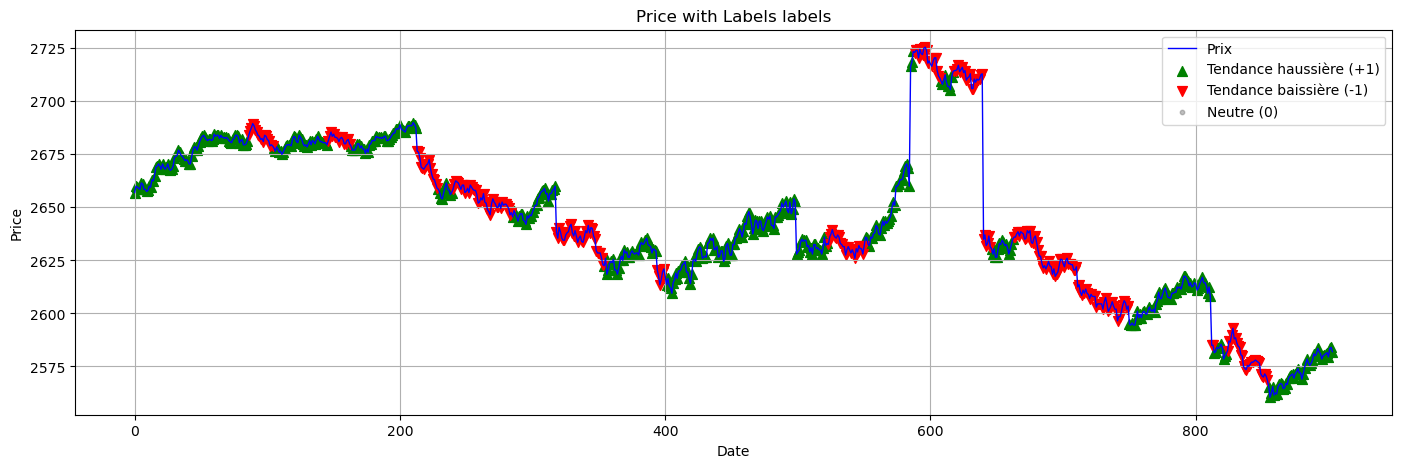

In [7]:
vol_window = 10
upper_barrier = 0.5
vertical_barrier = 20

lib.plot_price_with_labels(price_series=stacked_data['close'], label_series=stacked_data['labels'])

In [8]:
sample_weights, auxiliary = lib.get_samples_weights(
    labels_series=stacked_data['labels'], 
    price_series=stacked_data['close'], 
    vol_window=vol_window, 
    upper_barrier=upper_barrier, 
    vertical_barrier=vertical_barrier,
    n_jobs=1
)
stacked_data = pd.concat([stacked_data, sample_weights], axis=1)